In [1]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import pandas as pd
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

In [2]:
merged_dir = "../../../data/merged"
image_dir = "../../../images/knn"

# original data

In [33]:
train_file_path = os.path.join(merged_dir, "train_data.parquet")
train_data = pd.read_parquet(train_file_path)
test_file_path = os.path.join(merged_dir, "test_data.parquet")
test_data = pd.read_parquet(test_file_path)

In [34]:
# Prepare features and labels
X_train = train_data.drop(columns=['fire','longitude', 'latitude']).to_numpy()
y_train = train_data['fire'].to_numpy()

X_test = test_data.drop(columns=['fire','longitude', 'latitude']).to_numpy()
y_test = test_data['fire'].to_numpy()

In [5]:
knn = KNeighborsClassifier()

# Search space (ODD k only)
knn_space = {
    "n_neighbors": Categorical(list(range(1, 31, 2))),
    "weights": Categorical(["uniform", "distance"]),
    "p": Categorical([1, 2])
}

# Bayesian Search
knn_bayes = BayesSearchCV(
    estimator=knn,
    search_spaces=knn_space,
    n_iter=50,
    cv=5,
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,
    verbose=2,       
    return_train_score=True
)

# Fit
knn_bayes.fit(X_train, y_train)

# Best results
print("Best KNN params:", knn_bayes.best_params_)
print("Best CV f1_macro:", knn_bayes.best_score_)

# Test evaluation
y_pred_knn = knn_bayes.predict(X_test)
print("Test f1_macro:", f1_score(y_test, y_pred_knn, average="macro"))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\T14s\anaconda3\envs\dm-env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Test f1_macro: 0.8504361863518958


In [6]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_knn, target_names=[str(c) for c in set(y_test)], digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9664    0.9729    0.9697      7576
           1     0.7536    0.7101    0.7312       883

    accuracy                         0.9455      8459
   macro avg     0.8600    0.8415    0.8504      8459
weighted avg     0.9442    0.9455    0.9448      8459



In [7]:
# Convert cv results to DataFrame
results_knn = pd.DataFrame(knn_bayes.cv_results_)

# Sort by best CV score
results_knn = results_knn.sort_values(
    by="mean_test_score", ascending=False
)

# Display top 5
print(results_knn[
    ["mean_test_score", "std_test_score", "param_n_neighbors", "param_weights", "param_p"]
].head())

    mean_test_score  std_test_score  param_n_neighbors param_weights  param_p
8          0.841287        0.003952                 29      distance        2
30         0.840878        0.004335                 29      distance        1
39         0.840651        0.004581                 23      distance        2
11         0.840556        0.003569                 27      distance        2
31         0.840431        0.003846                 25      distance        2


In [8]:
results_knn.to_csv("knn_original_bayes_results.csv", index=False)

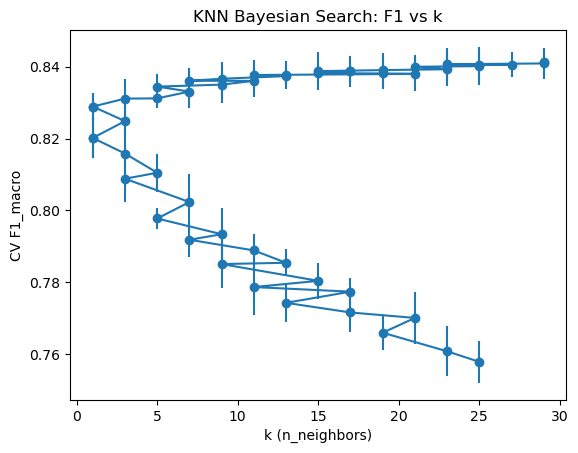

In [35]:
df_results = pd.read_csv("knn_original_bayes_results.csv")
import matplotlib.pyplot as plt
# Suppose df_results contains your Bayesian search results
plt.errorbar(
    df_results['param_n_neighbors'],
    df_results['mean_test_score'],
    yerr=df_results['std_test_score'],
    fmt='o-'
)
plt.xlabel("k (n_neighbors)")
plt.ylabel("CV F1_macro")
plt.title("KNN Bayesian Search: F1 vs k")
plt.savefig(os.path.join(image_dir, "knn_original_bayes_f1_vs_k.png"))
plt.show()

In [36]:
# print lines where k=3
# show only ["mean_test_score", "std_test_score", "param_n_neighbors", "param_weights", "param_p"]
print(df_results[df_results['param_n_neighbors'] == 3][
    ["mean_test_score", "std_test_score", "param_n_neighbors", "param_weights", "param_p"]
])

    mean_test_score  std_test_score  param_n_neighbors param_weights  param_p
25         0.831105        0.005407                  3      distance        1
28         0.824847        0.004509                  3      distance        2
31         0.815818        0.006968                  3       uniform        1
33         0.808830        0.006495                  3       uniform        2


In [37]:
# claculate prediction and classification report for k=3
knn_3 = KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)
knn_3.fit(X_train, y_train)
y_pred_knn_3 = knn_3.predict(X_test)
report = classification_report(y_test, y_pred_knn_3, target_names=[str(c) for c in set(y_test)], digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9694    0.9605    0.9649      7576
           1     0.6859    0.7395    0.7117       883

    accuracy                         0.9375      8459
   macro avg     0.8276    0.8500    0.8383      8459
weighted avg     0.9398    0.9375    0.9385      8459



# Smote Tomek

In [30]:
train_file_path = os.path.join(merged_dir, "train_smote_tomek.parquet")
train_data = pd.read_parquet(train_file_path)
test_file_path = os.path.join(merged_dir, "test_data.parquet")
test_data = pd.read_parquet(test_file_path)

In [31]:
# Prepare features and labels
X_train = train_data.drop(columns=['fire','longitude', 'latitude']).to_numpy()
y_train = train_data['fire'].to_numpy()

X_test = test_data.drop(columns=['fire','longitude', 'latitude']).to_numpy()
y_test = test_data['fire'].to_numpy()

In [11]:
knn = KNeighborsClassifier()


knn_space = {
    "n_neighbors": Categorical(list(range(1, 31, 2))),
    "weights": Categorical(["uniform", "distance"]),
    "p": Categorical([1, 2])
}

# Bayesian Search
knn_bayes = BayesSearchCV(
    estimator=knn,
    search_spaces=knn_space,
    n_iter=50,
    cv=5,
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,
    verbose=2,       
    return_train_score=True
)

# Fit
knn_bayes.fit(X_train, y_train)

# Best results
print("Best KNN params:", knn_bayes.best_params_)
print("Best CV f1_macro:", knn_bayes.best_score_)

# Test evaluation
y_pred_knn = knn_bayes.predict(X_test)
print("Test f1_macro:", f1_score(y_test, y_pred_knn, average="macro"))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\T14s\anaconda3\envs\dm-env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(1), np.int64(1), np.str_('uniform')] before, using random point [13, 2, 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\T14s\anaconda3\envs\dm-env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(11), np.int64(2), np.str_('distance')] before, using random point [5, 2, 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\T14s\anaconda3\envs\dm-env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(1), np.int64(1), np.str_('uniform')] before, using random point [17, 2, 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\T14s\anaconda3\envs\dm-env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(1), np.int64(1), np.str_('distance')] before, using random point [11, 2, 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best KNN params: OrderedDict([('n_neighbors', 1), ('p', 1), ('weights', 'distance')])
Best CV f1_macro: 0.9700442228526882
Test f1_macro: 0.830680728937605


In [12]:
# Generate classification report
report = classification_report(y_test, y_pred_knn, target_names=[str(c) for c in set(y_test)], digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9701    0.9545    0.9622      7576
           1     0.6567    0.7475    0.6992       883

    accuracy                         0.9329      8459
   macro avg     0.8134    0.8510    0.8307      8459
weighted avg     0.9374    0.9329    0.9347      8459



In [13]:
# Convert cv results to DataFrame
results_knn = pd.DataFrame(knn_bayes.cv_results_)

# Sort by best CV score
results_knn = results_knn.sort_values(
    by="mean_test_score", ascending=False
)

# Display top 5
print(results_knn[
    ["mean_test_score", "std_test_score", "param_n_neighbors", "param_weights", "param_p"]
].head())

    mean_test_score  std_test_score  param_n_neighbors param_weights  param_p
22         0.970044        0.004267                  1       uniform        1
20         0.970044        0.004267                  1      distance        1
28         0.965426        0.003022                  3      distance        1
23         0.965390        0.001999                  1       uniform        2
9          0.965390        0.001999                  1      distance        2


In [14]:
results_knn.to_csv("knn_sTomek_bayes_results.csv", index=False)

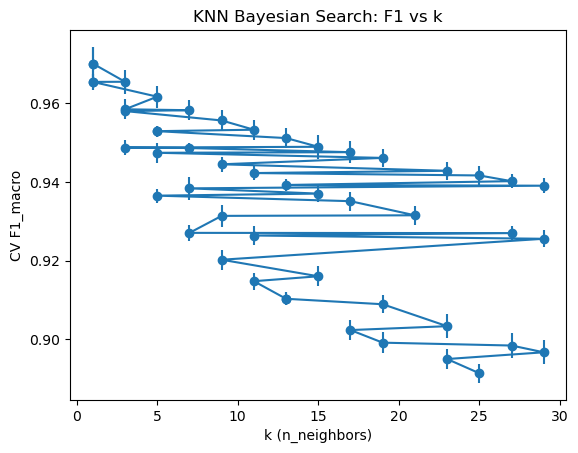

In [16]:
import matplotlib.pyplot as plt
df_results = pd.read_csv("knn_sTomek_bayes_results.csv")
plt.errorbar(
    df_results['param_n_neighbors'],
    df_results['mean_test_score'],
    yerr=df_results['std_test_score'],
    fmt='o-'
)
plt.xlabel("k (n_neighbors)")
plt.ylabel("CV F1_macro")
plt.title("KNN Bayesian Search: F1 vs k")
plt.savefig(os.path.join(image_dir, "knn_sTomek_bayes_f1_vs_k.png"))
plt.show()

In [28]:
df_results = pd.read_csv("knn_sTomek_bayes_results.csv")
# print lines where k=3
print(df_results[df_results['param_n_neighbors'] == 3][
    ["mean_test_score", "std_test_score", "param_n_neighbors", "param_weights", "param_p"]
])

    mean_test_score  std_test_score  param_n_neighbors param_weights  param_p
2          0.965426        0.003022                  3      distance        1
6          0.958435        0.002511                  3       uniform        1
8          0.957978        0.001619                  3      distance        2
15         0.948715        0.001849                  3       uniform        2


In [29]:
# print lines where k=5
print(df_results[df_results['param_n_neighbors'] == 5][
    ["mean_test_score", "std_test_score", "param_n_neighbors", "param_weights", "param_p"]
])

    mean_test_score  std_test_score  param_n_neighbors param_weights  param_p
5          0.961637        0.002767                  5      distance        1
11         0.952877        0.001435                  5      distance        2
12         0.952877        0.001435                  5      distance        2
18         0.947388        0.002479                  5       uniform        1
29         0.936497        0.001793                  5       uniform        2


In [32]:
# predict with k=3
knn_3 = KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)
knn_3.fit(X_train, y_train)
y_pred_3 = knn_3.predict(X_test)
# classification report
report = classification_report(y_test, y_pred_3, target_names=[str(c) for c in set(y_test)], digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9720    0.9440    0.9578      7576
           1     0.6149    0.7667    0.6825       883

    accuracy                         0.9255      8459
   macro avg     0.7934    0.8554    0.8201      8459
weighted avg     0.9347    0.9255    0.9291      8459

